# MNIST Latent Space

Workbook inspired by [N8python's latent space example](https://n8python.github.io/mnistLatentSpace/)

Library versions:
- Numpy: 1.19.5
- Tensorflow: 2.4.1
- Matplotlib: 3.4.0
- Python: 3.8.6

Another note here would be that if reproducibility is extremely important, then you should set up a docker file to run this code and possible other scripts, or (for testing) you could set up a python virtual environment (EX: venv or conda).

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, losses, metrics, utils, backend
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tensorflow.keras.models import Model, Sequential
import numpy as np
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
# Code in cell found at: https://stackoverflow.com/a/52897216/9659107

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1234

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# backend.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Data Exploration

In [4]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


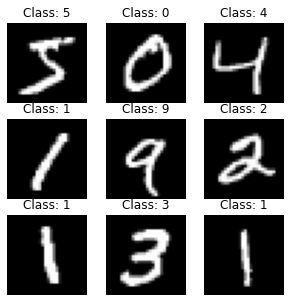

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5,5))
for x in range(3):
    for y in range(3):
        axes[x, y].set_title(f"Class: {train_y[x * 3 + y]}")
        axes[x, y].imshow(train_X[x * 3 + y], cmap ='gray')
        axes[x, y].axis('off')
    
plt.show()

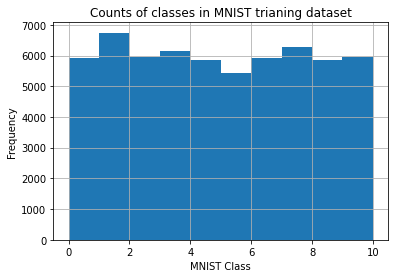

In [6]:
plt.hist(x=train_y, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('MNIST Class')
plt.ylabel('Frequency')
plt.title('Counts of classes in MNIST trianing dataset')
plt.grid(True)
plt.show()

## VAE Setup

In [7]:
class Sampling(layers.Layer):
    """
    Pulled from:
    https://keras.io/examples/generative/vae/

    Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
def create_vae_encoder_decoder():
    """
    Pulled from:
    https://keras.io/examples/generative/vae/
    """

    # Latent space = 2

    # Encoder
    encoder_inputs = Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)

    # Set up encoder latent layer
    z_mean = layers.Dense(2, name="z_mean")(x)
    z_log_var = layers.Dense(2, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(2,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

In [9]:
class VAE(Model):
    """
    Pulled from:
    https://keras.io/examples/generative/vae/

    Custom class for the Variational AutoEncoder.
    Class is needed for the custom loss function to 
    factor in latent space.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Run VAE and get encoder and decoder outputs
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Get normal loss using binary crossentropy
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # Calculate kl loss using latent space outputs
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Calculate final loss
            total_loss = reconstruction_loss + kl_loss
            
        # Apply losses and return
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # Needed to be added as call() mus be defined in this version of Keras
    def call(self, data):
        _, _, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction


In [10]:
encoder, decoder = create_vae_encoder_decoder()

In [11]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 7, 32)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 64)     18496       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

## Train VAE

In the original tutorial, the test dataset was passed as the validation data. This is not good as tuning your model using the test dataset would overfit and you would get higher output performance than you would generally expect. Since the data is already separated into a train/test split, we can just ask the function to split the input training dataset into training and validation. You could then evaluate the tuned model using the test dataset later.

In [14]:
processed_train_x = np.expand_dims(train_X, -1).astype("float32") / 255.0
processed_test_x = np.expand_dims(test_X, -1).astype("float32") / 1.0

print(train_X.shape)
print(processed_train_x.shape)

vae_train_history = vae.fit(processed_train_x,
                epochs=30,
                shuffle=True,
                validation_split=0.1)   # Use validation split here rather validation data

(60000, 28, 28)
(60000, 28, 28, 1)
Epoch 1/30
1688/1688 [==============================] - 64s 37ms/step - loss: 218.5726 - reconstruction_loss: 179.8780 - kl_loss: 4.2506 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/30
1688/1688 [==============================] - 62s 37ms/step - loss: 162.7032 - reconstruction_loss: 156.0237 - kl_loss: 5.2360 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/30
1688/1688 [==============================] - 61s 36ms/step - loss: 158.2561 - reconstruction_loss: 152.6113 - kl_loss: 5.4982 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/30
1688/1688 [==============================] - 60s 36ms/step - loss: 156.6494 - reconstruction_loss: 150.7264 - kl_loss: 5.6609 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/30
1688/1688 [=======================

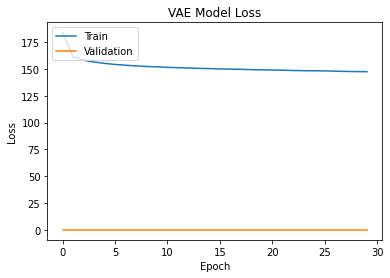

In [15]:
plt.plot(vae_train_history.history['loss'])
plt.plot(vae_train_history.history['val_total_loss'])
plt.title('VAE Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 2), (None, 2), (N 22996     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         65089     
Total params: 88,091
Trainable params: 88,085
Non-trainable params: 6
_________________________________________________________________


## Show Trained VAE Output

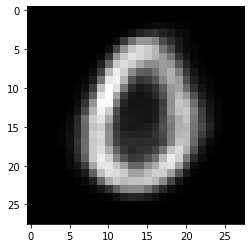

In [17]:
plt.imshow(vae.decoder.predict([[1, 1]])[0], cmap ='gray')

In [18]:
def plot_latent_space(vae, n=30, figsize=15):
    """Plot n digits over the latent space  of the VAE.
        Pulled from:
        https://keras.io/examples/generative/vae/

    Args:
        vae (VAE): VAE trained model
        n (int, optional): Number of digits to draw. Defaults to 30.
        figsize (int, optional): Figure size to show all digits. Defaults to 15.
    """
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

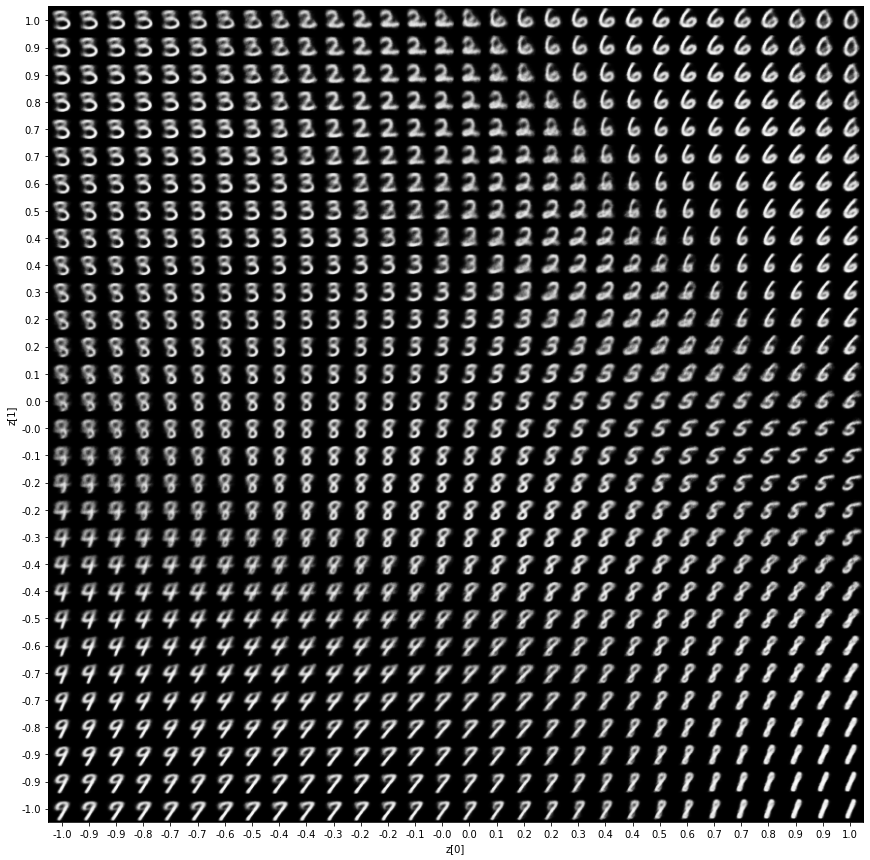

In [19]:
plot_latent_space(vae)

## Classifier Setup

In [20]:
def create_classifier_model():
    """
    Model pulled from:
    https://keras.io/examples/vision/mnist_convnet/
    """
    model = Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(500, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

In [21]:
classifier_model = create_classifier_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               8

## Train Classifier model

After plotting loss from the architecture in the youtube video, I noticed it was overfitting, so I added a droppout layer and another dense layer to get Test F1 Score up to 0.98 (was 0.96 when overfitting). The model just starts to overfit after epoch 10, so we want to stop then.

In [22]:
# convert class vectors to binary class matrices
num_classes = 10
y_train = utils.to_categorical(train_y, num_classes)
y_test = utils.to_categorical(test_y, num_classes)

classifier_train_history = classifier_model.fit(processed_train_x, y_train,
                epochs=10,
                shuffle=True,
                validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 54s 31ms/step - loss: 0.4138 - val_loss: 0.0452
Epoch 2/10
1688/1688 [==============================] - 52s 31ms/step - loss: 0.0835 - val_loss: 0.0351
Epoch 3/10
1688/1688 [==============================] - 56s 33ms/step - loss: 0.0641 - val_loss: 0.0341
Epoch 4/10
1688/1688 [==============================] - 55s 32ms/step - loss: 0.0554 - val_loss: 0.0291
Epoch 5/10
1688/1688 [==============================] - 53s 32ms/step - loss: 0.0448 - val_loss: 0.0235
Epoch 6/10
1688/1688 [==============================] - 53s 31ms/step - loss: 0.0441 - val_loss: 0.0260
Epoch 7/10
1688/1688 [==============================] - 53s 31ms/step - loss: 0.0384 - val_loss: 0.0242
Epoch 8/10
1688/1688 [==============================] - 53s 31ms/step - loss: 0.0346 - val_loss: 0.0232
Epoch 9/10
1688/1688 [==============================] - 52s 31ms/step - loss: 0.0340 - val_loss: 0.0233
Epoch 10/10
1688/1688 [==============================] - 52s 31m

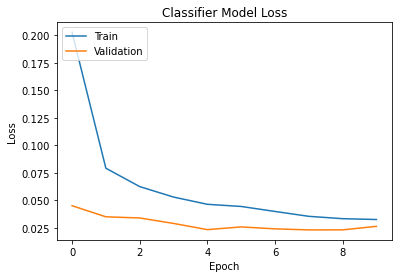

In [23]:
plt.plot(classifier_train_history.history['loss'])
plt.plot(classifier_train_history.history['val_loss'])
plt.title('Classifier Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
test_pred = classifier_model.predict(processed_test_x).argmax(axis=1)
print(f"Classifier test macro F1 score: {f1_score(test_y, test_pred, average='macro')}")
print(f"Classifier test micro F1 score: {f1_score(test_y, test_pred, average='micro')}")

Classifier test macro F1 score: 0.9478437738304931
Classifier test micro F1 score: 0.9449


## Explore Latent Space Using Models

In [25]:
# Send VAE prediction to the classifier and see if it can predict it
classifier_model.predict(vae.decoder.predict([[1, 1]])).argmax()

0

In [26]:
def plot_latent_space_classes(vae, classifier_model, n=100, figsize=5):
    figure = np.zeros((n, n, 3))
    rgb_class_colors = [
        [0.0, 0.0, 1.0],
        [0.0, 1.0, 1.0],
        [1.0, 0.0, 1.0],
        [1.0, 0.0, 0.0],
        [1.0, 1.0, 0.0],
        [1.0, 0.0, 0.5],
        [1.0, 0.5, 0.0],
        [0.0, 1.0, 0.0],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
    ]

    # Find the best confidences and their Z values
    # for each class to be plotted later.
    highest_confidences = {
        0: {
            "loc": [],
            "conf": 0.0
        },
        1: {
            "loc": [],
            "conf": 0.0
        },        
        2: {
            "loc": [],
            "conf": 0.0
        },
        3: {
            "loc": [],
            "conf": 0.0
        },
        4: {
            "loc": [],
            "conf": 0.0
        },
        5: {
            "loc": [],
            "conf": 0.0
        },
        6: {
            "loc": [],
            "conf": 0.0
        },
        7: {
            "loc": [],
            "conf": 0.0
        },
        8: {
            "loc": [],
            "conf": 0.0
        },
        9: {
            "loc": [],
            "conf": 0.0
        }        
    }

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

    plt.figure(figsize=(figsize, figsize))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            pred = classifier_model.predict(x_decoded)[0]
            digit = pred.argmax()
            pred_confidence = pred[digit]
            figure[i, j, 0] = rgb_class_colors[digit][0]
            figure[i, j, 1] = rgb_class_colors[digit][1]
            figure[i, j, 2] = rgb_class_colors[digit][2]

            if pred_confidence > highest_confidences[digit]["conf"]:
                highest_confidences[digit]["loc"] = z_sample
                highest_confidences[digit]["conf"] = pred_confidence

    legend_elements = []
    for i, (r, g, b) in enumerate(rgb_class_colors):
        legend_elements.append(Patch(facecolor=((r, g, b, 1.0)), label=f"{i}"))

    tick_distance = n // 5
    pixel_range = np.arange(0, 100, 20)
    sample_range_x = np.round(grid_x, 1)[::tick_distance]
    sample_range_y = np.round(grid_y, 1)[::tick_distance]
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    legend = plt.legend(handles=legend_elements, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=5)
    legend.set_title("MNIST Classes")
    plt.show()
    return highest_confidences

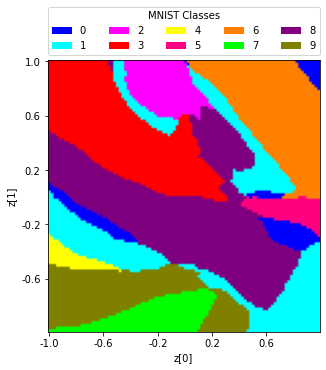

In [27]:
latent_space_highest_confidences = plot_latent_space_classes(vae, classifier_model)

### Where are the best made digits by VAE
Below shows where each digit is best made. The classifier can then say how well made that digit is by the confidence.

We can see that the worst digit to be made by the VAE is "4" with a confidence of 0.29.

In [28]:
latent_space_highest_confidences

{0: {'loc': array([[1., 1.]]), 'conf': 0.8046247},
 1: {'loc': array([[ 1., -1.]]), 'conf': 0.9980538},
 2: {'loc': array([[-0.21212121,  0.75757576]]), 'conf': 0.42041218},
 3: {'loc': array([[-0.93939394,  0.75757576]]), 'conf': 0.8320388},
 4: {'loc': array([[-1.        , -0.49494949]]), 'conf': 0.2858112},
 5: {'loc': array([[ 1.        , -0.15151515]]), 'conf': 0.56508535},
 6: {'loc': array([[0.5959596, 0.7979798]]), 'conf': 0.99560684},
 7: {'loc': array([[-0.27272727, -1.        ]]), 'conf': 0.8909244},
 8: {'loc': array([[ 0.13131313, -0.23232323]]), 'conf': 0.8731435},
 9: {'loc': array([[-1.        , -0.85858586]]), 'conf': 0.938088}}

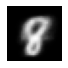

In [29]:
z0 = -0.3
z1 = -0.35
z_sample = np.array([[z0, z1]])
x_decoded = vae.decoder.predict(z_sample)[0].reshape(28, 28)
plt.figure(figsize=(1, 1))
plt.imshow(x_decoded, cmap="Greys_r")
plt.axis('off')
plt.show()

### View best made digits for each class by VAE

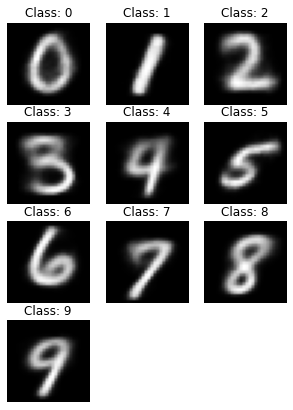

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5,7))
for x in range(4):
    for y in range(3):
        if x == 3 and y > 0:
            axes[x, y].axis('off')
            continue 

        int_class = x * 3 + y
        z_sample = np.array(latent_space_highest_confidences[int_class]["loc"])
        img = vae.decoder.predict(z_sample)[0].reshape(28, 28)
        axes[x, y].set_title(f"Class: {int_class}")
        axes[x, y].imshow(img, cmap ='gray')
        axes[x, y].axis('off')
    
plt.show()